In [1]:
import spot
spot.setup()
from spot.jupyter import display_inline

This notebook presents functions that can be used to solve the Reactive Synthesis problem using games.
If you are not familiar with how Spot represents games, please read the `games` notebook first.

In Reactive Synthesis, the goal is to build an electronic circuit that reacts to some input signals by producing some output signals, under some LTL constraints that tie both input and output.  Of course the input signals are not controllable, so only job is to decide what output signal to produce.

# Reactive synthesis in four steps

A strategy/control circuit can be derived more conveniently from an LTL/PSL specification.
The process is decomposed in three steps:
- Creating the game
- Solving the game
- Simplifying the winnning strategy
- Building the circuit from the strategy

Each of these steps is parametrized by a structure called `synthesis_info`.  This structure stores some additional data needed to pass fine-tuning options or to store statistics.

The `ltl_to_game` function takes the LTL specification, and the list of controllable atomic propositions (or output signals).  It returns a two-player game, where player 0 plays the input variables (and wants to invalidate the acceptance condition), and player 1 plays the output variables (and wants to satisfy the output condition).  The conversion from LTL to parity automata can use one of many algorithms, and can be specified in the `synthesis_info` structure (this works like the `--algo=` option of `ltlsynt`).

game has 29 states and 55 edges
output propositions are: o0


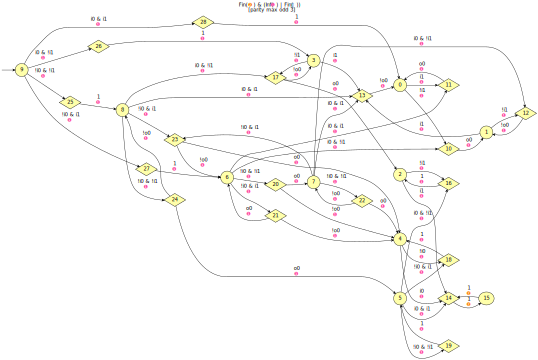

In [2]:
si = spot.synthesis_info()
si.s = spot.synthesis_info.algo_LAR # Use LAR algorithm

game = spot.ltl_to_game("G((F(i0) && F(i1))->(G(i1<->(X(o0)))))", ["o0"], si)
print("game has", game.num_states(), "states and", game.num_edges(), "edges")
print("output propositions are:", ", ".join(spot.get_synthesis_output_aps(game)))
display(game)

Solving the game, is done with `solve_game()` as with any game.  There is also a version that takes a `synthesis_info` as second argument in case the time it takes has to be recorded.  Here passing `si` or not makes no difference.

Found a solution: True


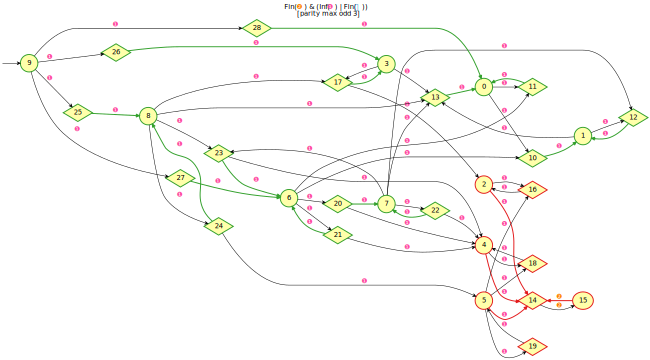

In [3]:
print("Found a solution:", spot.solve_game(game, si))
spot.highlight_strategy(game)
game.show('.g')

Once a strategy has been found, it can be extracted as an automaton and simplified using 6 different levels (the default is 2).  The output should be interpreted as a Mealy automaton, where transition have the form `(ins)&(outs)` where `ins` and `outs` are Boolean formulas representing possible inputs and outputs (they could be more than just conjunctions of atomic proposition).  Mealy machines with this type of labels are called "separated" in Spot.

simplification lvl  0 : No simplification


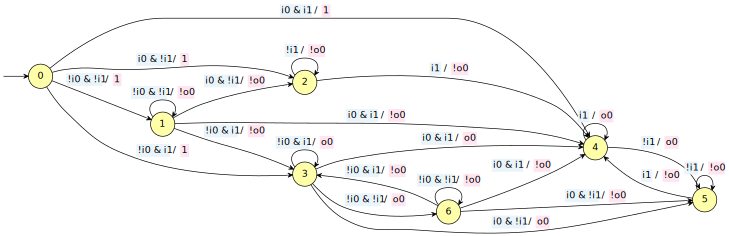

simplification lvl  1 : bisimulation-based reduction


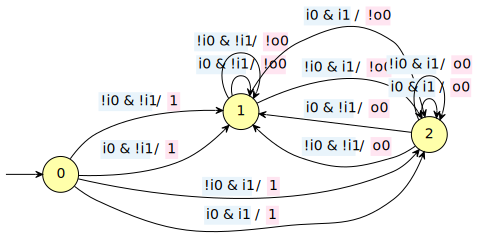

simplification lvl  2 : bisimulation-based reduction with output assignement


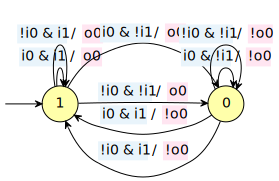

simplification lvl  3 : SAT-based exact minimization


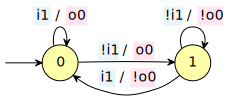

simplification lvl  4 : First 1 then 3 (exact)


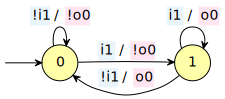

simplification lvl  5 : First 2 then 3 (not exact)


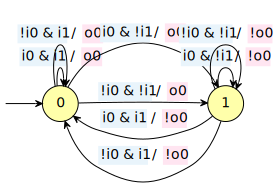

In [4]:
# We have different levels of simplification:
# 0 : No simplification
# 1 : bisimulation-based reduction
# 2 : bisimulation-based reduction with output assignement
# 3 : SAT-based exact minimization
# 4 : First 1 then 3 (exact)
# 5 : First 2 then 3 (not exact)

descr = ["0 : No simplification", 
         "1 : bisimulation-based reduction", 
         "2 : bisimulation-based reduction with output assignement",
         "3 : SAT-based exact minimization",
         "4 : First 1 then 3 (exact)",
         "5 : First 2 then 3 (not exact)"]


for i in range(6):
    print("simplification lvl ", descr[i])
    si.minimize_lvl = i
    mealy = spot.solved_game_to_mealy(game, si)
    spot.simplify_mealy_here(mealy, si.minimize_lvl, False)
    display(mealy)

If needed, a separated Mealy machine can be turned into game shape using `split_sepearated_mealy()`, which is more efficient than `split_2step()`.

In [5]:
display_inline(mealy, spot.split_separated_mealy(mealy), per_row=2)

# Converting the separated Mealy machine to AIG

A separated Mealy machine can be converted to a circuit in the [AIGER format](http://fmv.jku.at/aiger/FORMAT.aiger) using `mealy_machine_to_aig()`.  This takes a second argument specifying what type of encoding to use (exactly like `ltlsynt`'s `--aiger=...` option).  

In this case, the circuit is quite simple: `o0` should be the negation of previous value of `i1`.  This is done by storing the value of `i1` in a latch.  And the value if `i0` can be ignored.

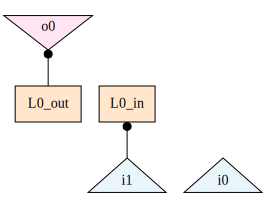

In [6]:
aig = spot.mealy_machine_to_aig(mealy, "isop")
display(aig)

While we are at it, let us mention that you can render those circuits horizontally as follows:

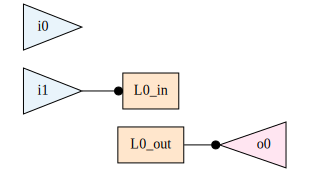

In [7]:
aig.show('h')

To encode the circuit in the AIGER format (ASCII version) use:

In [8]:
print(aig.to_str())

aag 3 2 1 1 0
2
4
6 3
7
i0 i1
i1 i0
o0 o0


# Adding more inputs and outputs by force

It can happen that propositions declared as output are ommited in the aig circuit (either because they are not part of the specification, or because they do not appear in the winning strategy).  In that case those 
values can take arbitrary values.

For instance so following constraint mention `o1` and `i1`, but those atomic proposition are actually unconstrained (`F(... U x)` can be simplified to `Fx`).  Without any indication, the circuit built will ignore those variables:

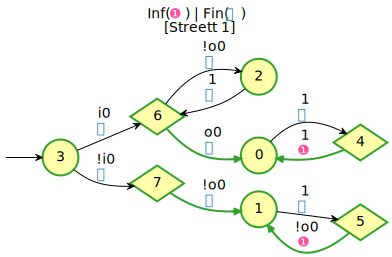

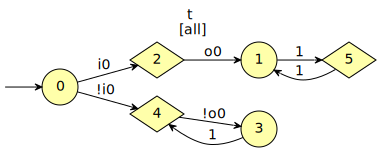

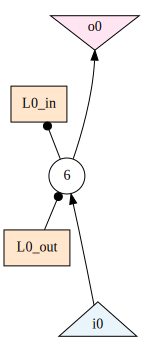

In [9]:
game = spot.ltl_to_game("i0 <-> F((Go1 -> Fi1) U o0)", ["o0", "o1"])
spot.solve_game(game)
spot.highlight_strategy(game)
display(game)
mealy = spot.solved_game_to_mealy(game)
display(mealy)
spot.simplify_mealy_here(mealy, 2, True)
display_inline(mealy, spot.unsplit_mealy(mealy))
aig = spot.mealy_machine_to_aig(mealy, "isop")
display(aig)

To force the presence of extra variables in the circuit, they can be passed to `mealy_machine_to_aig()`.

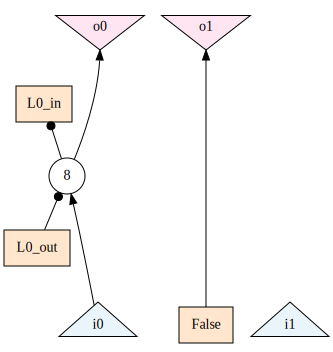

In [10]:
display(spot.mealy_machine_to_aig(mealy, "isop", ["i0", "i1"], ["o0", "o1"]))

# Combining Mealy machines

It can happen that the complete specification of the controller can be separated into sub-specifications with DISJOINT output propositions, see Finkbeiner et al. Specification Decomposition for Reactive Synthesis.
This results in multiple Mealy machines which have to be converted into one single AIG circuit.

This can be done in two ways:

1. Using the function `mealy_machines_to_aig()`, which takes a vector of separated Mealy machines as argument.
2. Combine the mealy machines into one before passing it to `mealy_machine_to aig(). This currently only supports input complete machines of the same type (mealy/separated mealy/split mealy)

Note that the method version is usually preferable as it is faster.
Also note that in order for this to work, all mealy machines need to share the same `bdd_dict`. This can be ensured by passing a common options strucuture.

Solved games:


Reduced strategies:


Circuit implementing both machines from a vector of machines:


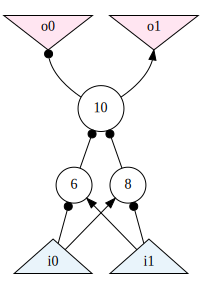

Combining the two machines into one.


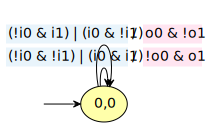

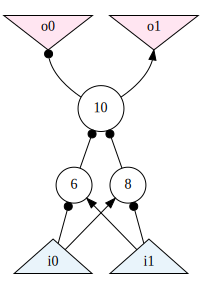

In [11]:
g1 = spot.ltl_to_game("G((i0 xor i1) <-> o0)", ["o0"], si)
g2 = spot.ltl_to_game("G((i0 xor i1) <-> (!o1))", ["o1"], si)
spot.solve_game(g1)
spot.highlight_strategy(g1)
spot.solve_game(g2)
spot.highlight_strategy(g2)
print("Solved games:")
display_inline(g1, g2)
strat1 = spot.solved_game_to_separated_mealy(g1)
strat2 = spot.solved_game_to_separated_mealy(g2)
print("Reduced strategies:")
display_inline(strat1, strat2)
#Method 1
print("Circuit implementing both machines from a vector of machines:")
aig = spot.mealy_machines_to_aig([strat1, strat2], "isop")
display(aig)
#Method 2
strat_comb = spot.mealy_product(strat1, strat2)
print("Combining the two machines into one.")
display(strat_comb)
aig_comb = spot.mealy_machine_to_aig(strat_comb, "isop")
display(aig_comb)

# Reading an AIGER-file

Note that we do not support the full [AIGER syntax](http://fmv.jku.at/aiger/FORMAT.aiger).  Our restrictions corresponds to the conventions used in the type of AIGER file we output:
- Input variables start at index 2 and are consecutively numbered.
- Latch variables start at index (1 + #inputs)×2 and are consecutively numbered.
- If some inputs or outputs are named in comments, all of them have to be named.
- Gate number $n$ can only connect to latches, inputs, or previously defined gates ($<n$).

In [12]:
aag_txt = """aag 5 2 0 2 3
2
4
10
6
6 2 4
8 3 5
10 7 9
i0 a
i1 b
o0 c
o1 d"""

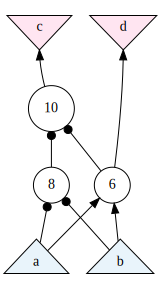

In [13]:
this_aig = spot.aiger_circuit(aag_txt)
display(this_aig)

In [14]:
print(this_aig.to_str())

aag 5 2 0 2 3
2
4
10
6
6 2 4
8 3 5
10 7 9
i0 a
i1 b
o0 c
o1 d


In [15]:
print(this_aig.gates())

((2, 4), (3, 5), (7, 9))


An AIG circuit can be transformed into a monitor/Mealy machine.  This can be used for instance to check that it does not intersect the negation of the specification.

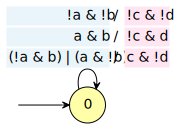

In [16]:
this_aig.as_automaton()

Note that the generation of aiger circuits from Mealy machines is flexible and accepts separated Mealy machines
as well as split Mealy machines.

In [17]:
strat1_s = spot.split_separated_mealy(strat1)
display_inline(strat1, strat1_s)
print(spot.get_synthesis_output_aps(strat1))
print(spot.get_synthesis_output_aps(strat1_s))

('o0',)
('o0',)


In [18]:
display_inline(spot.mealy_machine_to_aig(strat1, "isop"), spot.mealy_machine_to_aig(strat1_s, "isop"))